# PCA, TSNE and UMAP plots are generated on filtered datasets

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import utils_ML as uml
from sklearn.utils.class_weight import compute_class_weight

import sys
sys.path.append("../")
import AtlasAnalysisFunctions as AAF


In [52]:
# based on: https://towardsdatascience.com/coding-a-custom-imputer-in-scikit-learn-31bd68e541de

class LowestValueImputer(BaseEstimator, TransformerMixin):
    '''
    Imputes the lowest value in that column
    '''

    def __init__(self):
        self.fitted = False

    def fit(self, X, y = None):
        self.impute_map = X.min()

        # If protein columns has all nans, impute the lowest value in the dataframe
        self.impute_map = self.impute_map.fillna(self.impute_map.min())
        return self

    def transform(self, X, y=None):
        check_is_fitted(self, 'impute_map')
        
        X = X.copy()

        for index, row in self.impute_map.iteritems():
            ind = X.index[X.loc[:,index].isna()]
            X.loc[ind, index] = X.loc[ind, index].fillna(self.impute_map[index])
        
        return X

In [53]:
data = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

target_encoder = LabelEncoder()
targets = target_encoder.fit_transform(meta.Group)
unique_labels = pd.Series(targets).unique()
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=targets)

weights = {unique_labels[i]: class_weights[i] for i in range(len(unique_labels))}
print(weights)

KeyboardInterrupt: 

## Global filtering on occurence

In [ ]:
proteins, deleted = AAF._identify_global_reoccured_proteins(data.fillna(0), percentage_reoccurence=.5)
print(len(proteins))
global_data = data.loc[:,proteins]

2615


In [ ]:
imputer = LowestValueImputer()
imputer2 = KNNImputer(n_neighbors=10, weights='distance')
scaler = MinMaxScaler()

preprocessor = Pipeline(steps=[
        ("imputer", imputer2),
        ("scaler", scaler)
    ])

processed_data = preprocessor.fit_transform(global_data)

In [ ]:
meta

,project_id,filename,cell_id,cell_line,disease,treatment,tissue_type,sub_cell,organ_id,PXD_accession,all_PSM,sign_PSM,peptides,proteins,experiment_type,instrument,pmid,pool_id,ionbot_version,Group
assay_id,,,,,,,,,,,,,,,,,,,,
30960,1815,3B10-1,545,Hep3B,hepatocellular carcinoma,/,liver,/,NaN,PXD000533,11014,10578,9705,2401,in-solution,Q-exactive,24328083,1,IONBOT_v0.8.0,HCC
30961,1815,3B10-2,545,Hep3B,hepatocellular carcinoma,/,liver,/,NaN,PXD000533,11530,11036,10104,2449,in-solution,Q-exactive,24328083,2,IONBOT_v0.8.0,HCC
31008,1815,H10-1,546,MHCC97,hepatocellular carcinoma,/,liver,MHCC97H,NaN,PXD000533,11151,10296,9384,2368,in-solution,Q-exactive,24328083,3,IONBOT_v0.8.0,HCC
31009,1815,H10-2,546,MHCC97,hepatocellular carcinoma,/,liver,MHCC97H,NaN,PXD000533,11335,10567,9593,2390,in-solution,Q-exactive,24328083,4,IONBOT_v0.8.0,HCC
31102,1817,FASP_A_01,549,LAN5,neuroblastoma,A? Peptide,brain,/,NaN,PXD002842,202116,38271,12607,1449,FASP,LTQ Orbitrap Velos,28157316,0,IONBOT_v0.6.2,Neuroblastoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36558,1874,q02894,641,DU4475,carcinoma,/,breast,/,NaN,PXD008222,59593,8932,3072,935,in-solution,Q-exactive,28843283,44,IONBOT_v0.7.0,Ductal_breast
36563,1874,q02900,642,HCC1143,carcinoma,/,breast,/,NaN,PXD008222,41478,6100,2201,654,in-solution,Q-exactive,28843283,45,IONBOT_v0.7.0,Ductal_breast
36568,1874,q02906,642,HCC1143,carcinoma,/,breast,/,NaN,PXD008222,57389,8472,3101,833,in-solution,Q-exactive,28843283,46,IONBOT_v0.7.0,Ductal_breast


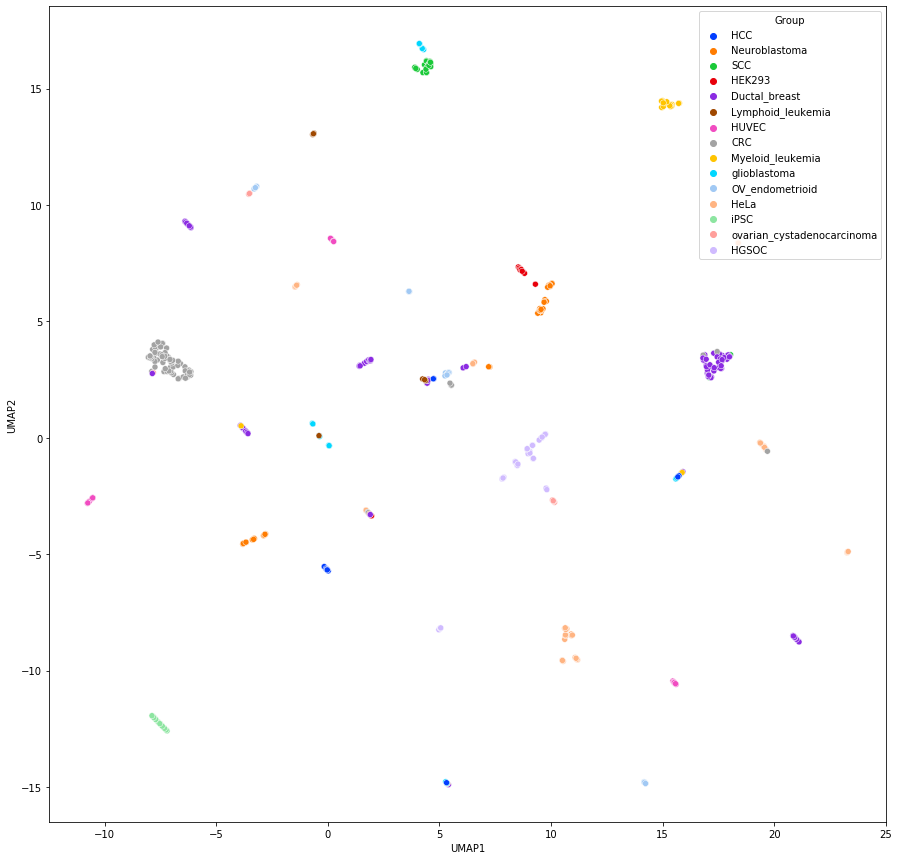

In [ ]:
reducer = UMAP(n_neighbors=5)
umap_embedding = reducer.fit_transform(processed_data)
plt.figure(figsize=(15,15))
sns.scatterplot(data=pd.DataFrame(umap_embedding, columns = ["UMAP1", "UMAP2"]), x= "UMAP1", y = "UMAP2", hue = meta.reset_index()["Group"], palette = colors)

In [ ]:
colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

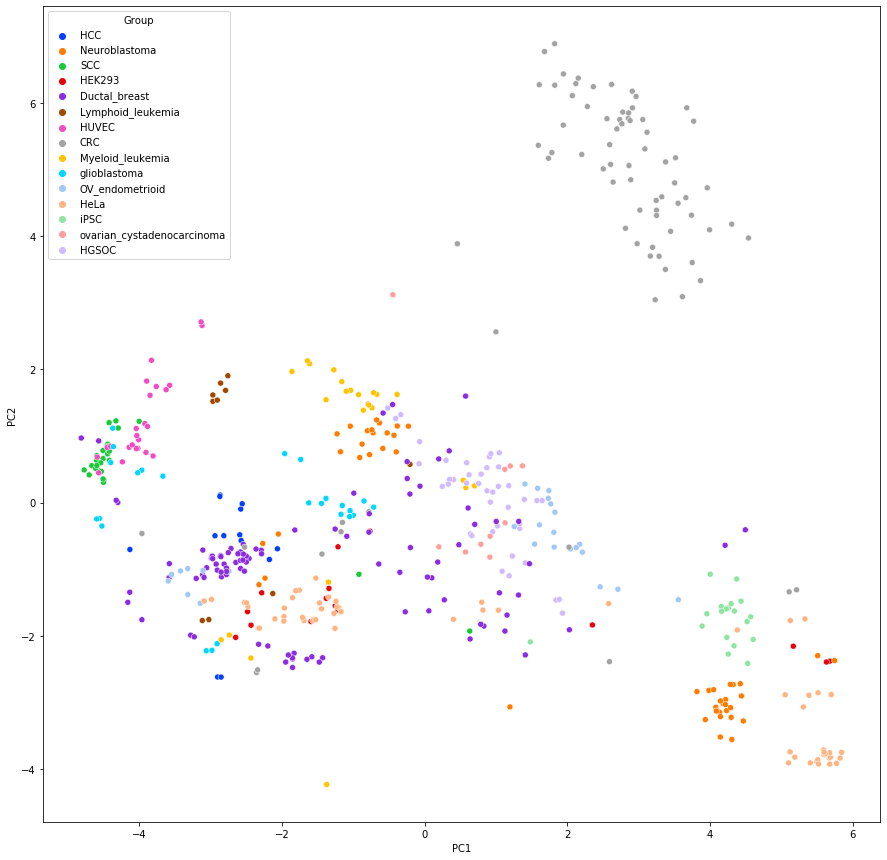

In [ ]:
pca = PCA(n_components=2)

embedding = pca.fit_transform(processed_data)
plt.figure(figsize=(15,15))
sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta.reset_index()["Group"], palette = colors)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


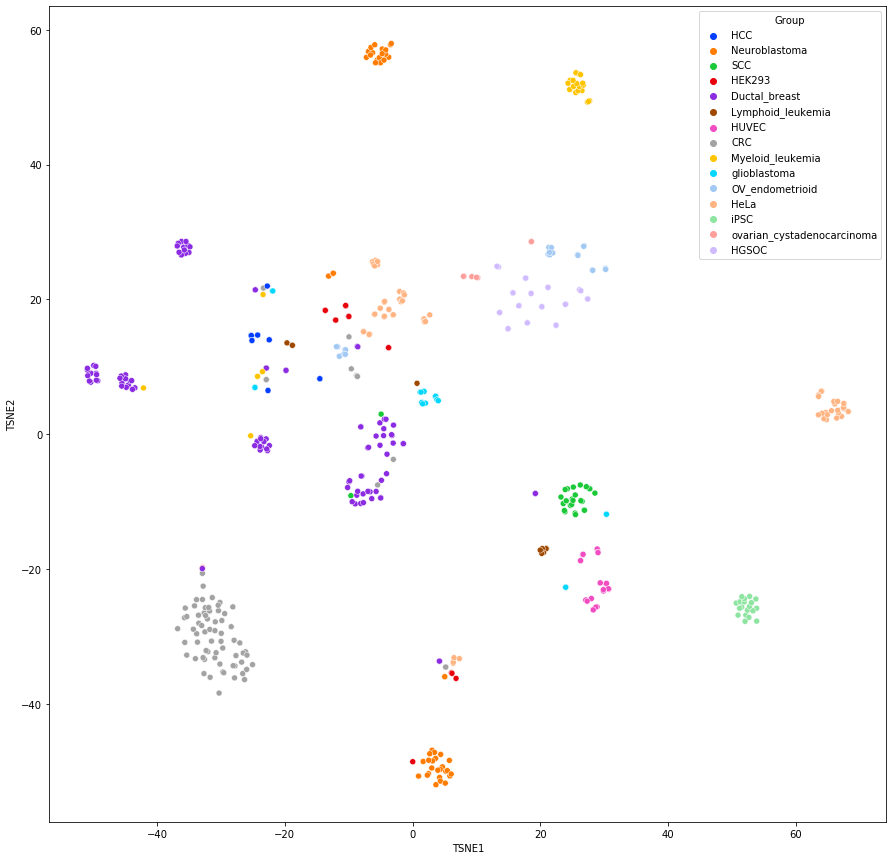

In [ ]:
tsne = TSNE(perplexity=15)

embedding = tsne.fit_transform(processed_data)
plt.figure(figsize=(15,15))
sns.scatterplot(data=pd.DataFrame(embedding, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette = colors)

In [ ]:
pipe = Pipeline(steps=[
    ('imputer', uml.LowestValueImputer()),
    ('scaler', MinMaxScaler())
])

filtering = uml.FilterByClass(keep=False, percentage=.9)
filtering.fit(data,targets)
filtered_data = filtering.transform(data,targets)

filtered_data = pipe.fit_transform(data)

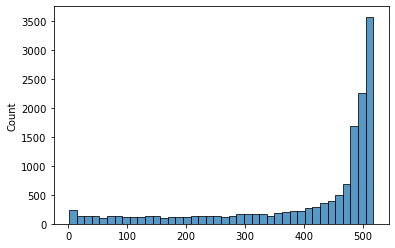

In [ ]:
sns.histplot((pd.DataFrame(filtered_data) == 0).sum(axis=0))

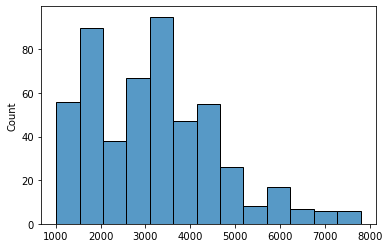

In [ ]:
sns.histplot((pd.DataFrame(filtered_data) != 0).sum(axis=1))

In [ ]:
all_prots = []
for cls, prots in filtering.filter_per_class.items():
    all_prots = all_prots + prots
len(set(all_prots))

4168

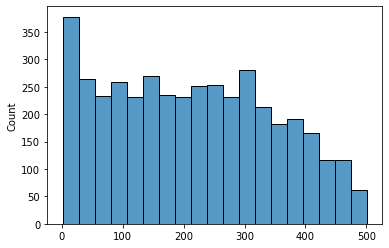

In [ ]:
sns.histplot((pd.DataFrame(filter_data) == 0).sum())

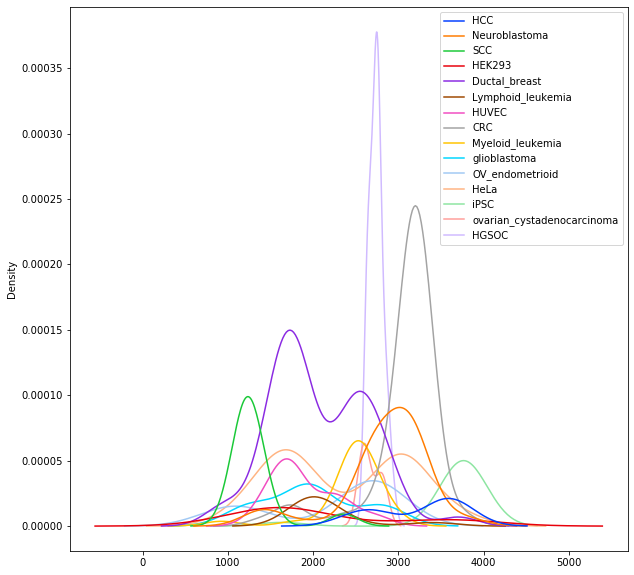

In [57]:
plt.figure(figsize=(10,10))
colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]
sns.kdeplot(x=(pd.DataFrame(filter_data) != 0).sum(axis=1), hue=meta.Group.values,palette=colors)

In [34]:
filter_data = pd.DataFrame(filtered_data, columns=data.columns).loc[:,list(set(all_prots))]

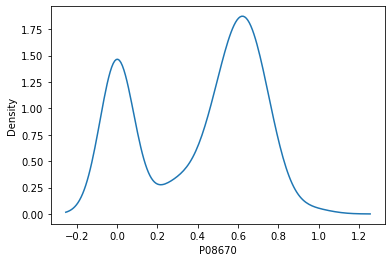

In [61]:
sns.kdeplot(filter_data.loc[:,"P08670"])

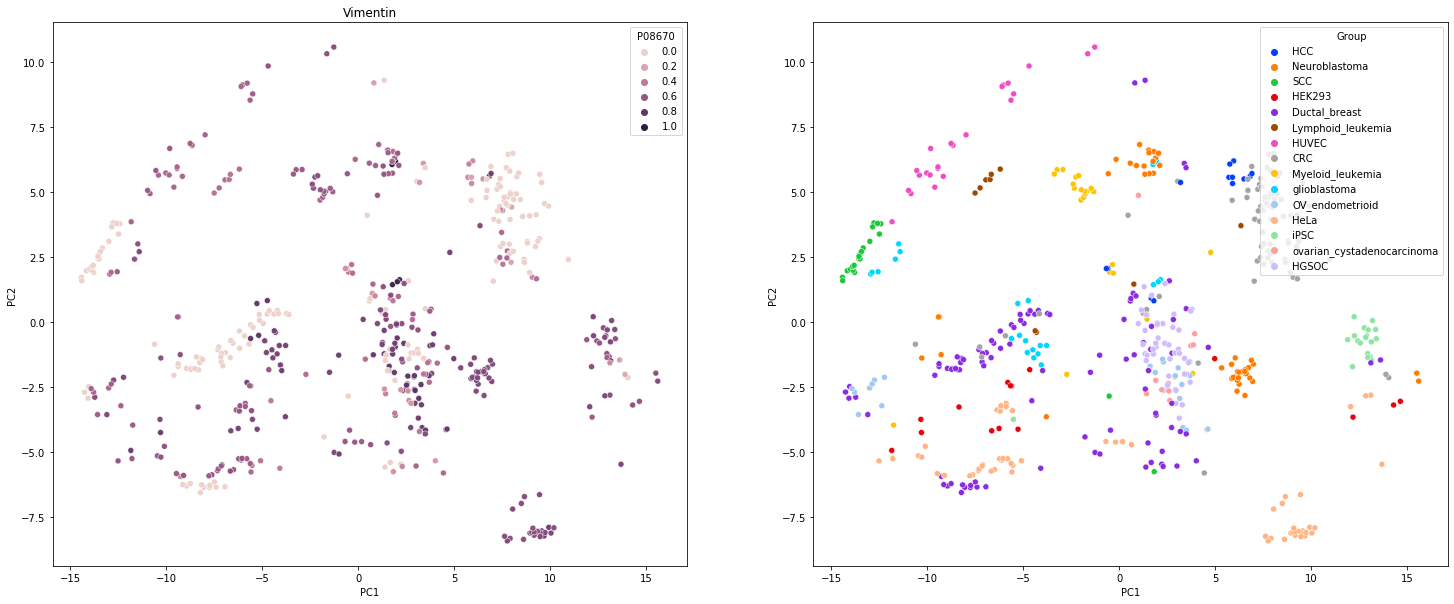

In [67]:
tsne = TSNE(perplexity=15)

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

embedding = PCA(n_components=2).fit_transform(filter_data)
fig,( ax1,ax2) = plt.subplots(1,2, figsize=(25,10))

ax1.set_title("Vimentin")

sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = filter_data.loc[:, "P08670"], ax=ax1)
sns.scatterplot(data=pd.DataFrame(embedding, columns = ["PC1", "PC2"]), x= "PC1", y = "PC2", hue = meta.reset_index()["Group"], palette = colors, ax=ax2)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


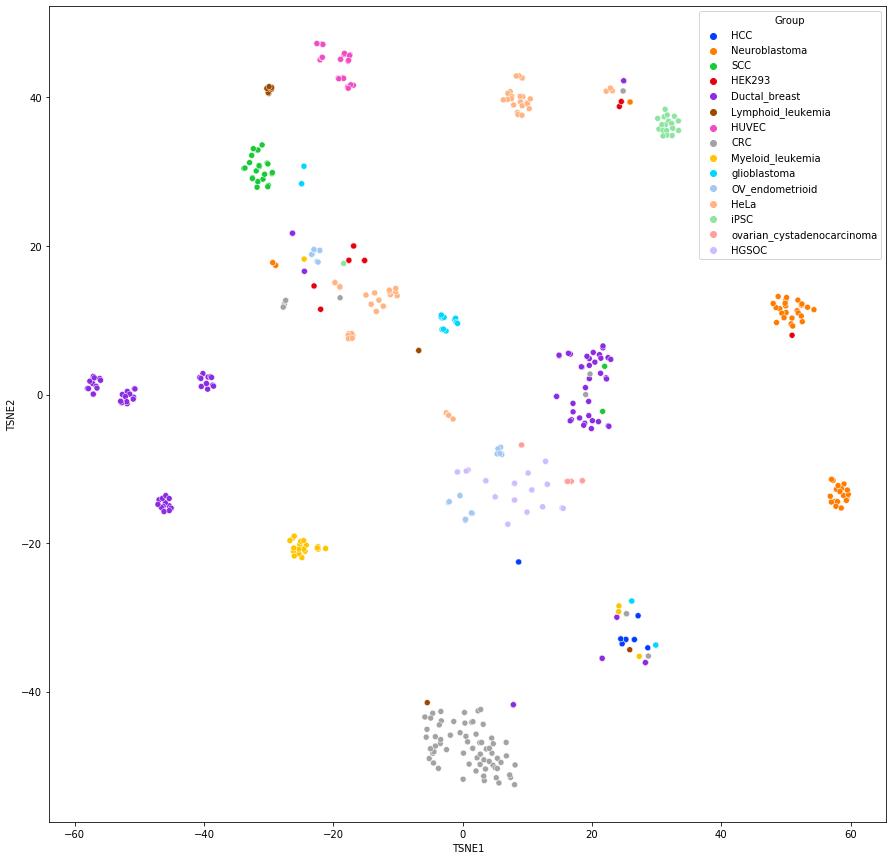

In [36]:
tsne = TSNE(perplexity=15)

colors = sns.color_palette("bright")+sns.color_palette("pastel")
colors = colors[:15]

embedding = tsne.fit_transform(filter_data)
plt.figure(figsize=(15,15))
sns.scatterplot(data=pd.DataFrame(embedding, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["Group"], palette = colors)

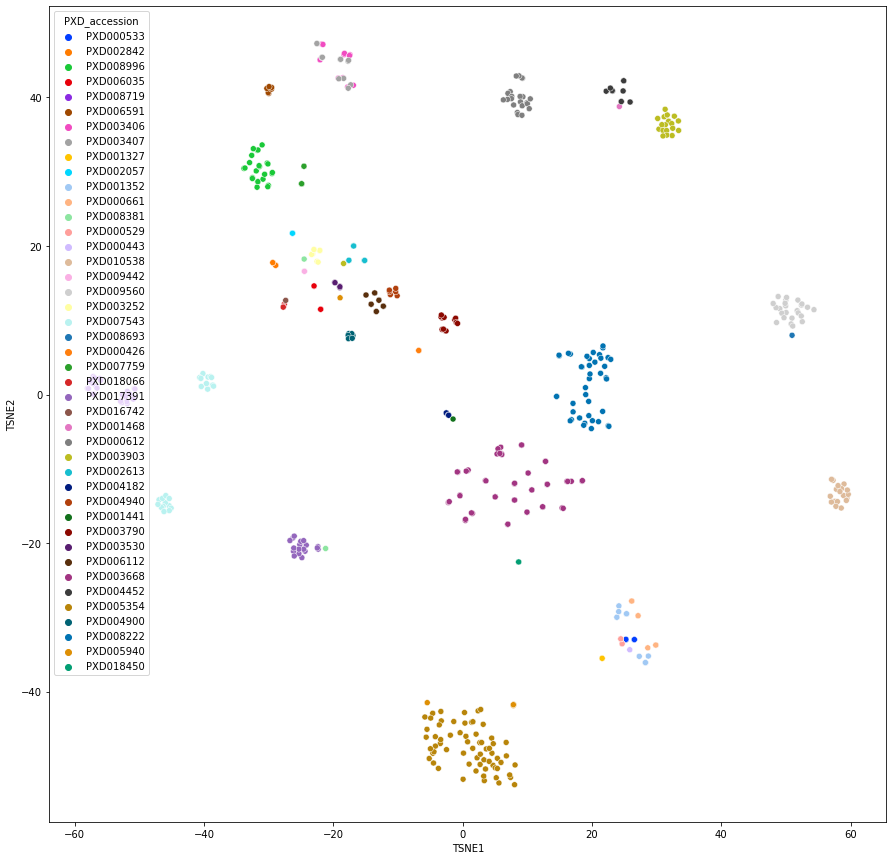

In [39]:
colors = sns.color_palette("bright")+sns.color_palette("pastel") + sns.color_palette("tab10") + sns.color_palette('dark') + sns.color_palette('colorblind')
colors = colors[:43]
plt.figure(figsize=(15,15))
sns.scatterplot(data=pd.DataFrame(embedding, columns = ["TSNE1", "TSNE2"]), x= "TSNE1", y = "TSNE2", hue = meta.reset_index()["PXD_accession"], palette = colors)